In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from anzu.emu_funcs import LPTEmulator

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'

plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = False
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 18

colors = ['#8d598f', '#cd9b00', '#de2d26', '#004d00', '#3182bd'][::-1]

The `LPTEmulator` object is the class that does all of our work. The emulator is trained on the default simulation data with fiducial parameters from 2101.11014 upon instantiation. 

It is possible to tweak some settings with kwargs provided to the `LPTEmulator` object, but this is generally not recommended unless you have very good reason to.

In [75]:
emu = LPTEmulator()

Now we're ready to make predictions. We can read in the Aemulus test cosmologies and measure the emulators accuracy on a set of simulations that it is not trained on. The default emulator makes predictions as a function of \\(\Omega_b h^2,\, \Omega_c h^2,\, w,\, n_s,\, \sigma_8,\, H_0,\, N_{\rm eff},\, a\\) in that order. 

In [76]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

# this is a helper function to set up an array to make predictions for all redshifts that there 
# are Aemulus snapshots for all Aemulus test cosmologies. It's not necessary to use this for 
# arbitrary cosmologies/redshifts. 

In [77]:
k = np.logspace(-2,0,100)

In [ ]:
pce_spec = emu.predict(k, np.atleast_2d(design_test))

Now we can plot the predictions, here just for \\( z=0\\) for the 7 test cosmologies.

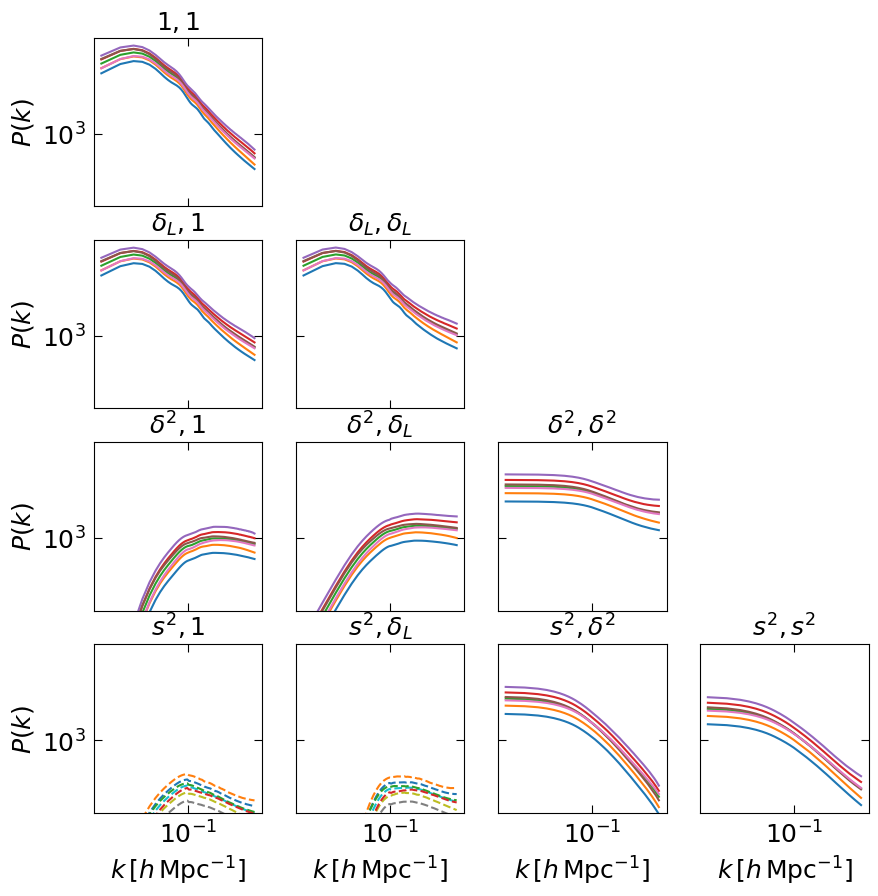

In [58]:
f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
components = ['1', '\delta_L', '\delta^2', 's^2']

pce_spec_reshape = pca_spec.reshape(7, 9, 10, -1)

#plot z=0 predictions
z_idx = -1 

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].loglog(emu.k[:emu.kmax_idx], pce_spec_reshape[:,z_idx,counter,:].T)
        l0 = ax[i,j].loglog(emu.k[:emu.kmax_idx], -pce_spec_reshape[:,z_idx,counter,:].T, ls='--')

        counter += 1
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))

        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'$P(k)$')


f.set_figheight(10)
f.set_figwidth(10)


For something a little more complicated, we can also test the accuracy of the emulator against the measured spectra from the Aemulus test boxes. Here we remake one of the accuracy figures from the original paper.

In [59]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

#read in CLEFT and Aemulus spectra for test cosmologies
dirname = '/'.join([os.path.abspath(''),'../anzu/data'])
spectra_lpt_test = np.load('{}/cleft_spectra_test.npy'.format(dirname))
spectra_aem_test = np.load('{}/spectra_aem_test_compensated_fixedgrowth.npy'.format(dirname))
spectra_aem_test_mean = np.nanmean(spectra_aem_test, axis=1)

#Set up some data for tests of PCA only 
spectra_lpt_test_extrap = emu._powerlaw_extrapolation(spectra_lpt_test)
simoverlpt_test = emu._ratio_and_smooth(spectra_aem_test_mean, spectra_lpt_test_extrap)

zidx = emu.zidx

spectra_aem_reshape = spectra_aem_test_mean[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_lpt_test_reshape = spectra_lpt_test[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_aem_test_mean = spectra_aem_test_mean[:,zidx:,...]


/Users/jderose/projects/anzu-devel/anzu/emu_funcs.py:256: RuntimeWarning: invalid value encountered in log10
  simoverlpt = np.log10(simoverlpt)


In [60]:
# Here is an example of how to make predictions when you have pure LPT spectra already computed by passing them in
# to the spectra_lpt kwarg of the predict function.

pce_spec = emu.predict(emu.k[:emu.kmax_idx], design_test, spectra_lpt=spectra_lpt_test_reshape)
pce_spec = pce_spec.reshape(7, emu.nz, 10, -1)

# Another variation of how to call predict, this time testing what happens if we want to make predictions
# Given the true PC components. This measures the accuracy of the PCA portion of the emulator.
pca_spec = emu.predict(emu.k[:emu.kmax_idx], design_test, spectra_lpt=spectra_lpt_test_reshape,
                                   evec_spec=emu.evec_spec[...,:2], simoverlpt=simoverlpt_test)
pca_spec = pca_spec.reshape(7, emu.nz, 10, -1)

kmax_idx = emu.kmax_idx
kmin_idx = emu.kmin_idx
k = emu.k
nz = emu.nz

resids_emu = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
resids_pca = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])

counter = 0
dk = k[1:] - k[:-1]

for i in range(4):
    for j in range(4):
        if j>i:
            continue

        for ki in range(nz):
            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]

        counter+=1

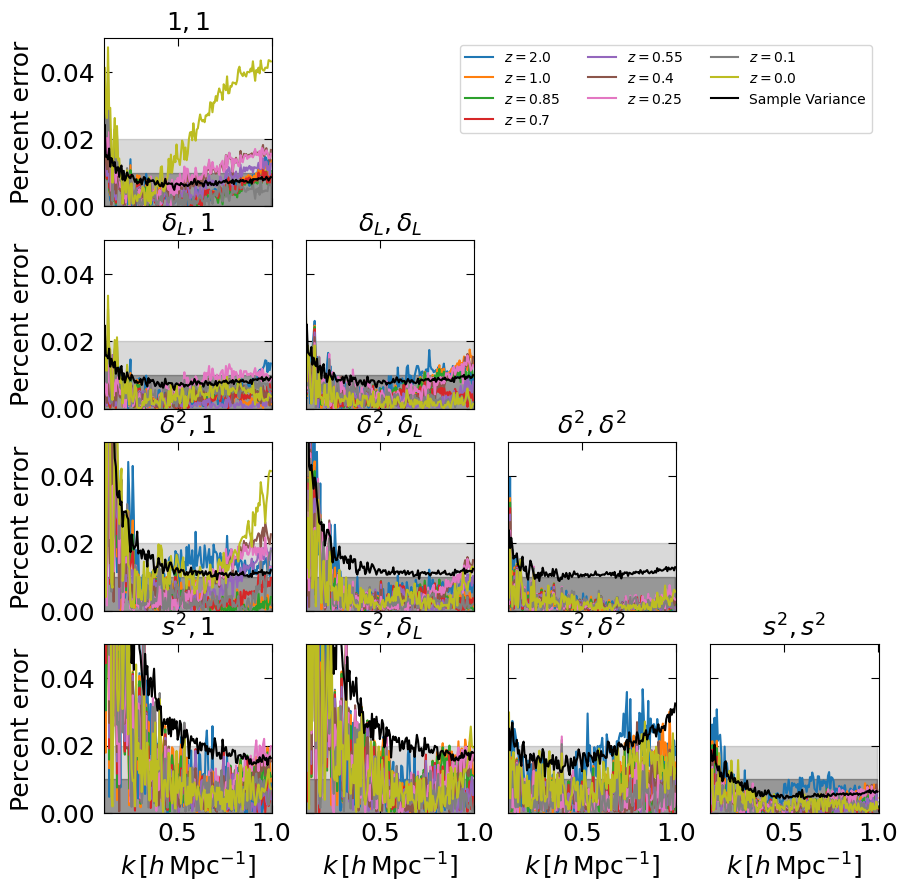

In [61]:
varpk = np.nanmean(np.nanstd(spectra_aem_test, axis=1), axis=(0,1))
meanpk = np.nanmean(np.nanmean(spectra_aem_test, axis=1), axis=(0,1))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.abs(resids_emu[tbcount,:,counter,kmin_idx:kmax_idx].T))
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[counter, kmin_idx:kmax_idx].T/np.abs(meanpk[counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)
